<a href="https://colab.research.google.com/github/lucaskydelima/Optimization-with-Python-Pyomo/blob/main/S2Example3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyomo

In [2]:
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

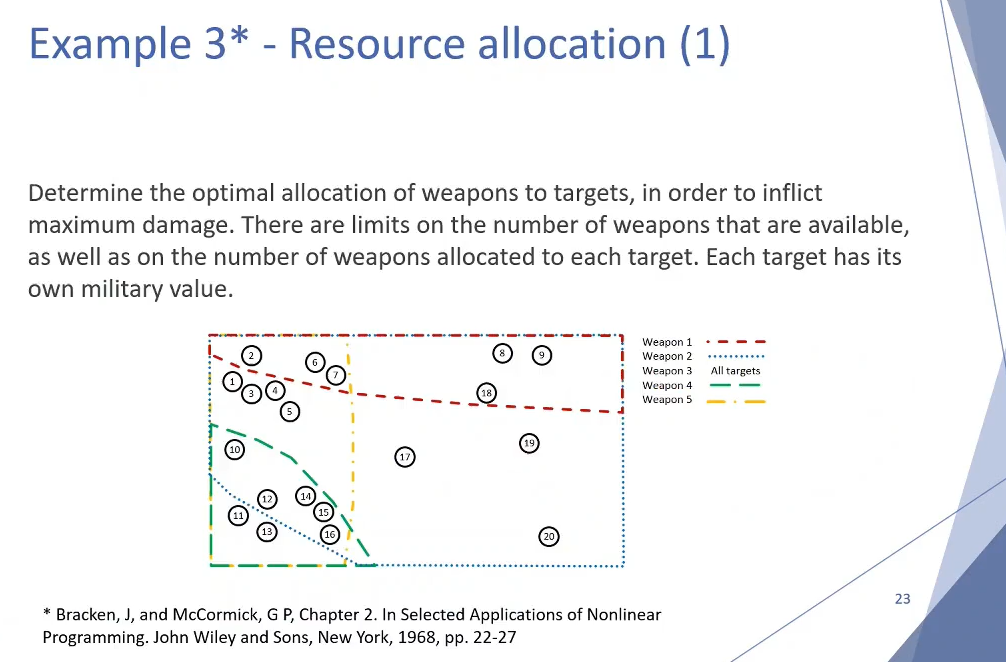

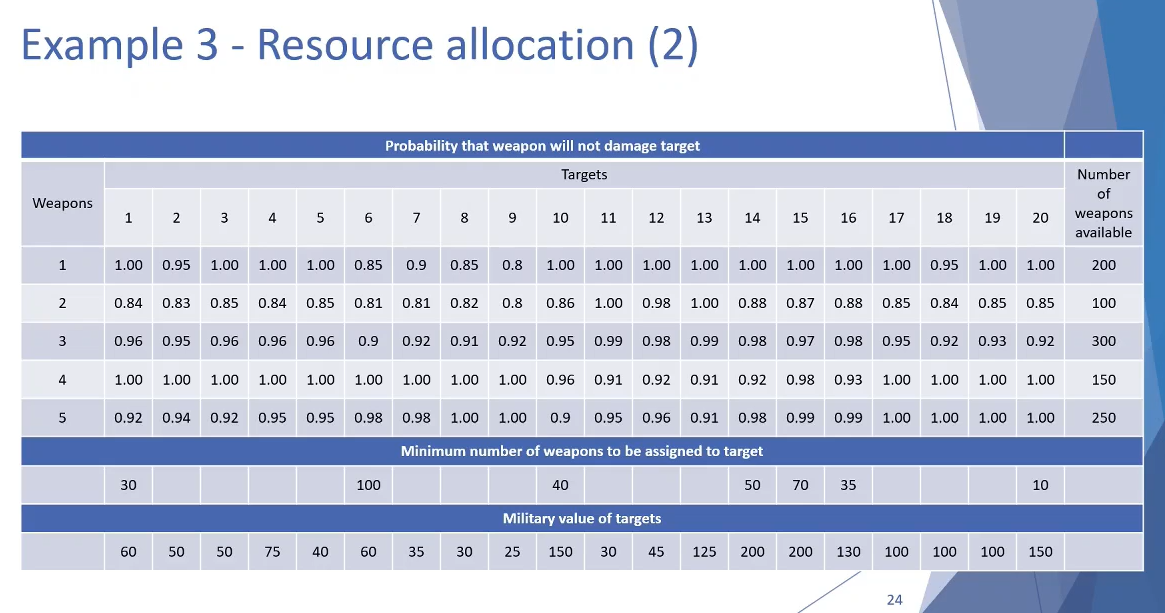

In [3]:
# Defining the model
model = pyo.ConcreteModel()

# Sets
model.w = pyo.Set(initialize=('ICBM', 'MRBM-1', 'LR-Bomber', 'F-Bomber', 'MRBM-2'))
model.t = pyo.RangeSet(1,20)

model.t_spec = pyo.Set(initialize=(1,6,10,14,15,16,20))

# Params
model.phi = pyo.Param(model.w, model.t, initialize={('ICBM',1):1.00,('ICBM',2):0.95,('ICBM',3):1.00,('ICBM',4):1.00,('ICBM',5):1.00,
                                                    ('ICBM',6):0.85,('ICBM',7):0.90,('ICBM',8):0.85,('ICBM',9):0.80,('ICBM',10):1.00,
                                                    ('ICBM',11):1.00,('ICBM',12):1.00,('ICBM',13):1.00,('ICBM',14):1.00,('ICBM',15):1.00,
                                                    ('ICBM',16):1.00,('ICBM',17):1.00,('ICBM',18):0.95,('ICBM',19):1.00,('ICBM',20):1.00,

                                                    ('MRBM-1',1):0.84,('MRBM-1',2):0.83,('MRBM-1',3):0.85,('MRBM-1',4):0.84,('MRBM-1',5):0.85,
                                                    ('MRBM-1',6):0.81,('MRBM-1',7):0.81,('MRBM-1',8):0.82,('MRBM-1',9):0.80,('MRBM-1',10):0.86,
                                                    ('MRBM-1',11):1.00,('MRBM-1',12):0.98,('MRBM-1',13):1.00,('MRBM-1',14):0.88,('MRBM-1',15):0.87,
                                                    ('MRBM-1',16):0.88,('MRBM-1',17):0.85,('MRBM-1',18):0.84,('MRBM-1',19):0.85,('MRBM-1',20):0.85, 

                                                    ('LR-Bomber',1):0.96,('LR-Bomber',2):0.95,('LR-Bomber',3):0.96,('LR-Bomber',4):0.96,('LR-Bomber',5):0.96,
                                                    ('LR-Bomber',6):0.90,('LR-Bomber',7):0.92,('LR-Bomber',8):0.91,('LR-Bomber',9):0.92,('LR-Bomber',10):0.95,
                                                    ('LR-Bomber',11):0.99,('LR-Bomber',12):0.98,('LR-Bomber',13):0.99,('LR-Bomber',14):0.98,('LR-Bomber',15):0.97,
                                                    ('LR-Bomber',16):0.98,('LR-Bomber',17):0.95,('LR-Bomber',18):0.92,('LR-Bomber',19):0.93,('LR-Bomber',20):0.92,

                                                    ('F-Bomber',1):1.00,('F-Bomber',2):1.00,('F-Bomber',3):1.00,('F-Bomber',4):1.00,('F-Bomber',5):1.00,
                                                    ('F-Bomber',6):1.00,('F-Bomber',7):1.00,('F-Bomber',8):1.00,('F-Bomber',9):1.00,('F-Bomber',10):0.96,
                                                    ('F-Bomber',11):0.91,('F-Bomber',12):0.92,('F-Bomber',13):0.91,('F-Bomber',14):0.92,('F-Bomber',15):0.98,
                                                    ('F-Bomber',16):0.93,('F-Bomber',17):1.00,('F-Bomber',18):1.00,('F-Bomber',19):1.00,('F-Bomber',20):1.00,

                                                    ('MRBM-2',1):0.92,('MRBM-2',2):0.94,('MRBM-2',3):0.92,('MRBM-2',4):0.95,('MRBM-2',5):0.95,
                                                    ('MRBM-2',6):0.98,('MRBM-2',7):0.98,('MRBM-2',8):1.00,('MRBM-2',9):1.00,('MRBM-2',10):0.90,
                                                    ('MRBM-2',11):0.95,('MRBM-2',12):0.96,('MRBM-2',13):0.91,('MRBM-2',14):0.98,('MRBM-2',15):0.99,
                                                    ('MRBM-2',16):0.99,('MRBM-2',17):1.00,('MRBM-2',18):1.00,('MRBM-2',19):1.00,('MRBM-2',20):1.00})

# Total number weapons available per type w
model.alpha = pyo.Param(model.w, initialize={'ICBM':200, 'MRBM-1':100, 'LR-Bomber':300, 'F-Bomber':150, 'MRBM-2':250})

# Military value of targets per type t
model.beta = pyo.Param(model.t, initialize={1:60, 2:50, 3:50, 4:75, 5:40, 6:60, 7:35, 8:30, 9:25, 10:150,
                                            11:30, 12:45, 13:125, 14:200, 15:200, 16:130, 17:100, 18:100, 19:100, 20:150})

# Minimum number of weapons to be assigned to specified targets 
model.gama = pyo.Param(model.t_spec, initialize={1:30, 6:100, 10:40, 14:50, 15:70, 16:35, 20:10})

# Decision Variable (NLP problems - its variables should always be defined as continuous)
model.x = pyo.Var(model.w, model.t, domain=pyo.NonNegativeReals)

# Objective Function
from functools import reduce
import operator

def prod(iterable):
  return reduce(operator.mul, iterable, 1)

def Objective_rule(model):
  return sum(model.beta[t] * (1-prod(model.phi[w,t]**model.x[w,t] for w in model.w)) for t in model.t)

model.obj = pyo.Objective(rule=Objective_rule, sense=pyo.maximize, doc = 'Total expected damage done to targets')

# Constraints
def Constraint_1(model, w):
  return sum(model.x[w,t] for t in model.t) <= model.alpha[w]

model.const1 = pyo.Constraint(model.w, rule=Constraint_1, doc = 'upper limit on number of weapons assigned based on availability')

def Constraint_2(model, t_spec):
  return sum(model.x[w,t_spec] for w in model.w) >= model.gama[t_spec]
  
model.const2 = pyo.Constraint(model.t_spec, rule=Constraint_2, doc = 'lower limit on weapons assigned')

# Solve
os.environ['NEOS_EMAIL'] = 'lucaskydelima@gmail.com'
results = pyo.SolverManagerFactory('neos').solve(model, opt='ipopt')

results.write()
print("\n RESULTS \n")
print('Total expected damage = ', model.obj())
for w in model.w:
  for t in model.t:
    if(model.x[w,t]() > 1):
      print('Number of weapons of type',w,'assigned to target', t, '=>', model.x[w,t]())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 12
  Number of variables: 100
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.14.5\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

 RESULTS 

Total expected damage =  1735.56958